In [13]:
### test analysis module
import pydrodelta.analysis 
import json
import matplotlib.pyplot as plt


In [14]:
#### load configuration
bordes_config = json.load(open("pydrodelta_config/bajo_uruguay.json"))


In [15]:
#### validate configuration
import jsonschema
schema = open("schemas/topology.json")
schema = json.load(schema)


In [16]:
try:
    jsonschema.validate(instance=bordes_config,schema=schema)
except jsonschema.exceptions.ValidationError as err:
    print(err)
print("Given JSON data is Valid")
#### instantiate boundarySet class from config file (.xml)
topology = pydrodelta.analysis.Topology(bordes_config)
topology


Given JSON data is Valid


In [17]:
#### load data
topology.loadData()
### sanitize timeseries
topology.removeOutliers()
topology.detectJumps()


False

In [18]:
topology.regularize()


In [19]:
topology.applyMovingAverage()
topology.applyOffset()


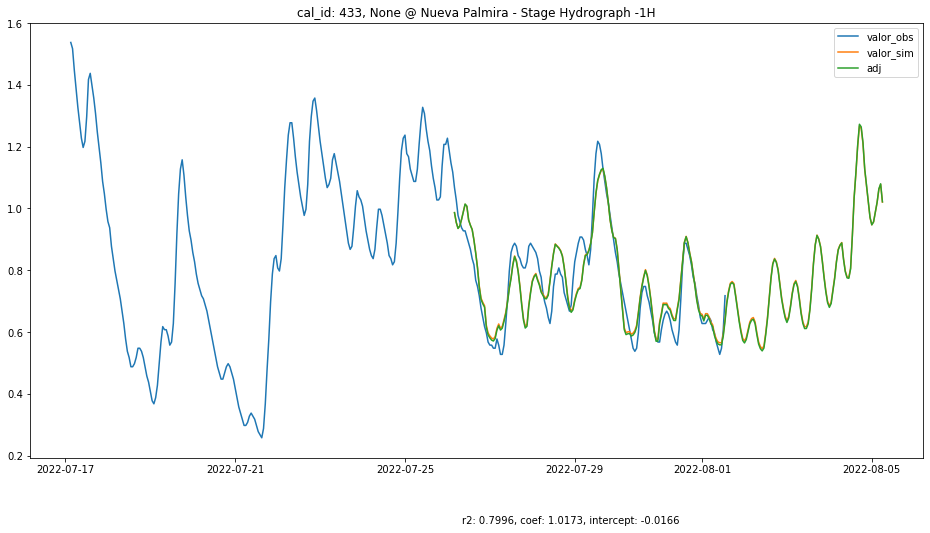

In [20]:
#### adjust
topology.adjust()

In [21]:
topology.fillNulls()

In [22]:
topology.concatenateProno()

In [23]:
from datetime import timedelta
topology.interpolate(timedelta(days=1))

In [11]:
topology.saveData("tmp/bajo_uruguay.csv",pivot=True)

In [28]:
from datetime import timedelta
topology.nodes[0].interpolate(limit=timedelta(hours=24))


In [15]:
node = topology.nodes[0]
from datetime import timedelta
node.interpolate(limit=timedelta(hours=12))


In [24]:
data = topology.nodes[1].data
data["valor"]


timestart
2022-07-17 00:00:00-03:00    1.5375
2022-07-17 01:00:00-03:00    1.5175
2022-07-17 02:00:00-03:00    1.4475
2022-07-17 03:00:00-03:00    1.3875
2022-07-17 04:00:00-03:00    1.3275
                              ...  
2022-08-06 09:00:00-03:00       NaN
2022-08-06 10:00:00-03:00       NaN
2022-08-06 11:00:00-03:00       NaN
2022-08-06 12:00:00-03:00       NaN
2022-08-06 13:00:00-03:00       NaN
Freq: <DateOffset: days=0, hours=1, minutes=0>, Name: valor, Length: 494, dtype: float64

In [8]:
data = topology.nodes[0].series[0].data
data["valor"]


timestart
2022-07-17 00:00:00-03:00    6985.0
2022-07-17 01:00:00-03:00       NaN
2022-07-17 02:00:00-03:00       NaN
2022-07-17 03:00:00-03:00       NaN
2022-07-17 04:00:00-03:00       NaN
                              ...  
2022-07-31 19:00:00-03:00       NaN
2022-07-31 20:00:00-03:00       NaN
2022-07-31 21:00:00-03:00       NaN
2022-07-31 22:00:00-03:00       NaN
2022-07-31 23:00:00-03:00       NaN
Freq: <DateOffset: days=0, hours=1, minutes=0>, Name: valor, Length: 360, dtype: float64

In [17]:
import pandas
topology.nodes[0].data[~pandas.isna(topology.nodes[0].data["valor"])].index.max()

Timestamp('2022-08-05 12:00:00-0300', tz='America/Argentina/Buenos_Aires', freq='<DateOffset: days=0, hours=1, minutes=0>')

In [ ]:
import pydrodelta.util as util
# int_data = util.interpolateData(data,interpolation_limit=12,tag_column="tag")
data["interpolated"] = data["valor"].interpolate(method='time',limit=48,limit_direction='both',limit_area='inside')

timestart
2022-07-17 00:00:00-03:00    6985
2022-07-17 01:00:00-03:00     NaN
2022-07-17 02:00:00-03:00     NaT
2022-07-17 03:00:00-03:00     NaT
2022-07-17 04:00:00-03:00     NaT
                             ... 
2022-07-31 19:00:00-03:00     NaT
2022-07-31 20:00:00-03:00     NaT
2022-07-31 21:00:00-03:00     NaT
2022-07-31 22:00:00-03:00     NaT
2022-07-31 23:00:00-03:00     NaT
Freq: <DateOffset: days=0, hours=1, minutes=0>, Name: valor, Length: 360, dtype: object

In [15]:
data["timestart"] = data.index

In [16]:
data["timestart"].diff()

timestart
2022-07-13 00:00:00-03:00               NaT
2022-07-13 01:00:00-03:00   0 days 01:00:00
2022-07-13 02:00:00-03:00   0 days 01:00:00
2022-07-13 03:00:00-03:00   0 days 01:00:00
2022-07-13 04:00:00-03:00   0 days 01:00:00
                                  ...      
2022-08-02 14:00:00-03:00   0 days 01:00:00
2022-08-02 15:00:00-03:00   0 days 01:00:00
2022-08-02 16:00:00-03:00   0 days 01:00:00
2022-08-02 17:00:00-03:00   0 days 01:00:00
2022-08-02 18:00:00-03:00   0 days 01:00:00
Freq: <DateOffset: days=0, hours=1, minutes=0>, Name: timestart, Length: 499, dtype: timedelta64[ns]

In [142]:
import pandas
from datetime import timedelta

node = topology.nodes[1]
node.time_interval = timedelta(hours=1)
data = node.data
# regular = topology.nodes[1].regularize()
data = data.reset_index()

data = data[data["timestart"].dt.hour % 6 == 0][data["timestart"].dt.minute==0]
data["timestart"] = data["timestart"].map(lambda x: x + timedelta(minutes=-15))
data = data.set_index("timestart")


/tmp/ipykernel_14117/3943787870.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[data["timestart"].dt.hour % 6 == 0][data["timestart"].dt.minute==0]


In [143]:
regular_index = node.createDatetimeIndex()
regular_data = pandas.DataFrame(index=regular_index)
regular_data.index.rename("timestart",True)
time_interval = node.time_interval / 2 # takes half time interval as maximum time distance for interpolation
jdata = regular_data.join(data,how="outer")
jdata = jdata.reset_index()
jdata["diff_with_previous"] = jdata["timestart"].diff()
jdata["diff_with_next"] = jdata["timestart"].diff(periods=-1)
jdata = jdata.set_index("timestart")
jdata["interpolated_backward"] = jdata["valor"].interpolate(method='time',limit=1,limit_direction='backward',limit_area=None)
jdata["interpolated_forward"] = jdata["valor"].interpolate(method='time',limit=1,limit_direction='forward',limit_area=None)
jdata["interpolated_backward_filtered"] = [ x.valor if -x["diff_with_next"] > time_interval else x.interpolated_backward for (i,x) in jdata.iterrows()]
jdata["interpolated_forward_filtered"] = [ x.valor if x["diff_with_previous"] > time_interval else x.interpolated_forward for (i,x) in jdata.iterrows()]
jdata["interpolated_final"] = [x.interpolated_backward_filtered if pandas.isna(x.interpolated_forward_filtered) else x.interpolated_forward_filtered for (i,x) in jdata.iterrows()]
jdata["new_tag"] = [x.tag if pandas.isna(x.interpolated_final) else "interpolated" if pandas.isna(x.valor) else x.tag for (i,x) in jdata.iterrows()]
regular_data = regular_data.join(jdata[["interpolated_final","new_tag"]].rename(columns={"interpolated_final":"valor","new_tag":"tag"}), how = 'left')

In [6]:
import pydrodelta.util as util
import pandas


In [33]:
node = topology.nodes[0]
serie = node.series[0]
data = serie.data
column="valor"
tag_column="tag"
df_regular = pandas.DataFrame(index = util.createDatetimeSequence(data.index, node.time_interval, topology.timestart, topology.timeend, topology.time_offset))
df_regular.index.rename('timestart', inplace=True)	 
df_join = df_regular.join(data, how = 'outer')


In [34]:
def f1(row):
    if -row["diff_with_next"] > timedelta_threshold:
        return row[column]
    else:
        return row["interpolated_backward"]

def f2(row):
    if row["diff_with_previous"] > timedelta_threshold:
        return row[column]
    else:
        return row["interpolated_forward"]

def f3(row):
    if pandas.isna(row["interpolated_forward_filtered"]):
        return row["interpolated_backward_filtered"]
    else:
        return row["interpolated_forward_filtered"]

In [35]:
    # if interpolate:
    #     # Interpola
    #     min_obs_date, max_obs_date = (df_join[~pandas.isna(df_join[column])].index.min(),df_join[~pandas.isna(df_join[column])].index.max())
    #     df_join["interpolated"] = df_join[column].interpolate(method='time',limit=interpolation_limit,limit_direction='both',limit_area=None if extrapolate else 'inside')
    #     if tag_column is not None:
    #         # print("columns: " + df_join.columns)
    #         df_join[tag_column] = [x[tag_column] if pandas.isna(x["interpolated"]) else "extrapolated" if i < min_obs_date or i > max_obs_date else "interpolated" if pandas.isna(x[column]) else x[tag_column] for (i, x) in df_join.iterrows()]
    #     df_join[column] = df_join["interpolated"]
    #     del df_join["interpolated"]
    #     df_regular = df_regular.join(df_join, how = 'left')
    # else:
timedelta_threshold = node.time_interval / 2 # takes half time interval as maximum time distance for interpolation
df_join = df_join.reset_index()
df_join["diff_with_previous"] = df_join["timestart"].diff()
df_join["diff_with_next"] = df_join["timestart"].diff(periods=-1)
df_join = df_join.set_index("timestart")
df_join["interpolated_backward"] = df_join[column].interpolate(method='time',limit=1,limit_direction='backward',limit_area=None)
df_join["interpolated_forward"] = df_join[column].interpolate(method='time',limit=1,limit_direction='forward',limit_area=None)
df_join["interpolated_backward_filtered"] = df_join.apply(lambda row: f1(row),axis=1)
df_join["interpolated_forward_filtered"] = df_join.apply(lambda row: f2(row),axis=1) #[x[column] if x["diff_with_previous"] > timedelta_threshold else x.interpolated_forward for (i,x) in df_join.iterrows()]
df_join["interpolated_final"] = df_join.apply(lambda row: f3(row),axis=1) # [x.interpolated_backward_filtered if pandas.isna(x.interpolated_forward_filtered) else x.interpolated_forward_filtered for (i,x) in df_join.iterrows()]


In [44]:
def findex(row):
    return (row.name).isoformat()
data.apply(lambda row: findex(row),axis=1)  

timestart
2022-07-17 00:00:00-03:00    2022-07-17T00:00:00-03:00
2022-07-18 00:00:00-03:00    2022-07-18T00:00:00-03:00
2022-07-19 00:00:00-03:00    2022-07-19T00:00:00-03:00
2022-07-20 00:00:00-03:00    2022-07-20T00:00:00-03:00
2022-07-21 00:00:00-03:00    2022-07-21T00:00:00-03:00
2022-07-22 00:00:00-03:00    2022-07-22T00:00:00-03:00
2022-07-23 00:00:00-03:00    2022-07-23T00:00:00-03:00
2022-07-24 00:00:00-03:00    2022-07-24T00:00:00-03:00
2022-07-25 00:00:00-03:00    2022-07-25T00:00:00-03:00
2022-07-26 00:00:00-03:00    2022-07-26T00:00:00-03:00
2022-07-27 00:00:00-03:00    2022-07-27T00:00:00-03:00
2022-07-28 00:00:00-03:00    2022-07-28T00:00:00-03:00
2022-07-29 00:00:00-03:00    2022-07-29T00:00:00-03:00
dtype: object

In [25]:
df_join["interpolated_backward_filtered"] = df_join.apply(lambda row: f1(row), axis=1) 

In [36]:
df_join["interpolated_final"]

timestart
2022-07-17 00:00:00-03:00    6985.0
2022-07-17 01:00:00-03:00       NaN
2022-07-17 02:00:00-03:00       NaN
2022-07-17 03:00:00-03:00       NaN
2022-07-17 04:00:00-03:00       NaN
                              ...  
2022-07-31 19:00:00-03:00       NaN
2022-07-31 20:00:00-03:00       NaN
2022-07-31 21:00:00-03:00       NaN
2022-07-31 22:00:00-03:00       NaN
2022-07-31 23:00:00-03:00       NaN
Name: interpolated_final, Length: 360, dtype: float64

In [ ]:
if tag_column is not None:
    df_join["new_tag"] = [x[tag_column] if pandas.isna(x.interpolated_final) else "interpolated" if pandas.isna(x.valor) else x[tag_column] for (i,x) in df_join.iterrows()]
    df_regular = df_regular.join(df_join[["interpolated_final","new_tag"]].rename(columns={"interpolated_final":column,"new_tag":tag_column}), how = 'left')
else:
    df_regular = df_regular.join(df_join[["interpolated_final",]].rename(columns={"interpolated_final":column}), how = 'left')
# return df_regular

In [19]:
df_join["interpolated_forward_filtered"]#["valor"]#

timestart
2022-07-17 00:00:00-03:00    6985
2022-07-17 01:00:00-03:00     NaN
2022-07-17 02:00:00-03:00     NaT
2022-07-17 03:00:00-03:00     NaT
2022-07-17 04:00:00-03:00     NaT
                             ... 
2022-07-31 19:00:00-03:00     NaT
2022-07-31 20:00:00-03:00     NaT
2022-07-31 21:00:00-03:00     NaT
2022-07-31 22:00:00-03:00     NaT
2022-07-31 23:00:00-03:00     NaT
Name: interpolated_forward_filtered, Length: 360, dtype: object